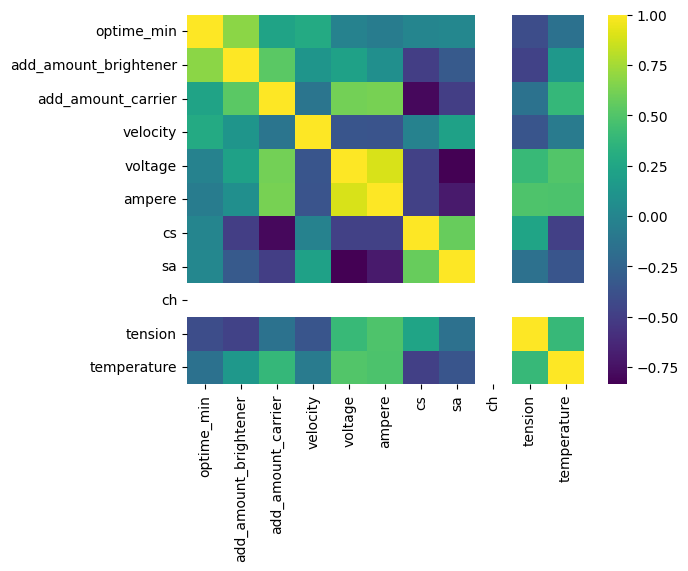

(17, 11)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import datetime
import scipy
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns

# 1. Load Raw Data
csv_raw = pd.read_csv("./data/data.csv", skiprows=1, parse_dates=['datetime'], dayfirst=False)
# 2. extract usable raw component(columns) ordered by datatime
raw_data = csv_raw[['datetime', 'warmup', 'off', 
                   'add_amount_brightener', 'add_amount_carrier', 
                   'velocity','tension','v','a','temperature',
                   'copper_sulfate_content', 'sulfuric_acid_content', 'chloride_content']].sort_values("datetime")

# 3. extracted column data
raw_warmup = raw_data[~raw_data["warmup"].isna()][["datetime", "warmup"]]
raw_off = raw_data[~raw_data["off"].isna()][["datetime", "off"]]
raw_brightener = (raw_data[~raw_data["add_amount_brightener"].isna()])[["datetime", "add_amount_brightener"]]
raw_carrier = (raw_data[~raw_data["add_amount_carrier"].isna()])[["datetime", "add_amount_carrier"]]
raw_velocity = (raw_data[~raw_data["velocity"].isna()])[["datetime", "velocity"]]
raw_tension = (raw_data[~raw_data["tension"].isna()])[["datetime", "tension"]]
raw_voltage = (raw_data[~raw_data["v"].isna()])[["datetime", "v"]]
raw_ampere = (raw_data[~raw_data["a"].isna()])[["datetime", "a"]]
raw_temperature = (raw_data[~raw_data["temperature"].isna()])[["datetime", "temperature"]]
raw_cs = (raw_data[~raw_data["copper_sulfate_content"].isna()])[["datetime", "copper_sulfate_content"]]
raw_sa = (raw_data[~raw_data["sulfuric_acid_content"].isna()])[["datetime", "sulfuric_acid_content"]]
raw_c = (raw_data[~raw_data["chloride_content"].isna()])[["datetime", "chloride_content"]]

#4. Create new data frame (for every single day operation)
raw_ext = pd.DataFrame(dtype=float, columns=['datetime', 'optime', 'optime_min', 'add_amount_brightener', 'add_amount_carrier', 
                                             'velocity', 'velocity_var', 'velocity_std',
                                             'tension','tension_var', 'tension_std',
                                             'voltage','voltage_var', 'voltage_std',
                                             'ampere','ampere_var', 'ampere_std',
                                             'temperature','temperature_var', 'temperature_std',
                                             'cs','cs_var', 'cs_std',
                                             'sa','sa_var', 'sa_std',
                                             'ch','c_var', 'c_std'])

#5. Calculate operation time (every single day)
for warmup, off in zip(raw_warmup.iterrows(), raw_off.iterrows()):
    value = [off[1]["datetime"], off[1]["datetime"]-warmup[1]["datetime"]]
    value.extend([np.nan for i in range(0, raw_ext.shape[1]-len(value))])
    raw_ext.loc[len(raw_ext.index)] = value

raw_ext = raw_ext.groupby(pd.Grouper(key='datetime', freq='D', sort=True)).sum()
raw_ext = raw_ext[raw_ext["optime"]!=datetime.timedelta(seconds=0)] # drop no timedelta
raw_ext["optime_min"] = [i.total_seconds()/60 for i in raw_ext.loc[:,"optime"]] # add time min
raw_ext = raw_ext.drop(columns="optime")


for t_idx in raw_ext.index:
    mask_brightener = list((raw_brightener["datetime"]>t_idx) & (raw_brightener["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_carrier = list((raw_carrier["datetime"]>t_idx) & (raw_carrier["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_voltage = list((raw_voltage["datetime"]>t_idx) & (raw_voltage["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_ampere = list((raw_ampere["datetime"]>t_idx) & (raw_ampere["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_temperature = list((raw_temperature["datetime"]>t_idx) & (raw_temperature["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_tension = list((raw_tension["datetime"]>t_idx) & (raw_tension["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_velocity = list((raw_velocity["datetime"]>t_idx) & (raw_velocity["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_cs = list((raw_cs["datetime"]>t_idx) & (raw_cs["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_sa = list((raw_sa["datetime"]>t_idx) & (raw_sa["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_c = list((raw_c["datetime"]>t_idx) & (raw_c["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    
    if any(mask_brightener):
        raw_ext.loc[t_idx, "add_amount_brightener"] = raw_brightener.loc[mask_brightener, "add_amount_brightener"].values[0]
    if any(mask_carrier):
        raw_ext.loc[t_idx, "add_amount_carrier"] = raw_carrier.loc[mask_carrier, "add_amount_carrier"].values[0]
    if any(mask_voltage):
        raw_ext.loc[t_idx, "voltage"] = raw_voltage.loc[mask_voltage, "v"].values.mean()
        raw_ext.loc[t_idx, "voltage_var"] = raw_voltage.loc[mask_voltage, "v"].values.var()
        raw_ext.loc[t_idx, "voltage_std"] = raw_voltage.loc[mask_voltage, "v"].values.std()
    if any(mask_ampere):
        raw_ext.loc[t_idx, "ampere"] = raw_ampere.loc[mask_voltage, "a"].values.mean()
        raw_ext.loc[t_idx, "ampere_var"] = raw_ampere.loc[mask_voltage, "a"].values.var()
        raw_ext.loc[t_idx, "ampere_std"] = raw_ampere.loc[mask_voltage, "a"].values.std()
    if any(mask_temperature):
        raw_ext.loc[t_idx, "temperature"] = raw_temperature.loc[mask_temperature, "temperature"].values.mean()
        raw_ext.loc[t_idx, "temperature_var"] = raw_temperature.loc[mask_temperature, "temperature"].values.var()
        raw_ext.loc[t_idx, "temperature_std"] = raw_temperature.loc[mask_temperature, "temperature"].values.std()
    if any(mask_cs):
        raw_ext.loc[t_idx, "cs"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].values.mean()
        raw_ext.loc[t_idx, "cs_var"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].values.var()
        raw_ext.loc[t_idx, "cs_std"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].values.std()
    if any(mask_sa):
        raw_ext.loc[t_idx, "sa"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].values.mean()
        raw_ext.loc[t_idx, "sa_var"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].values.var()
        raw_ext.loc[t_idx, "sa_std"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].values.std()
    if any(mask_c):
        raw_ext.loc[t_idx, "ch"] = raw_c.loc[mask_cs, "chloride_content"].values.mean()
        raw_ext.loc[t_idx, "ch_var"] = raw_c.loc[mask_cs, "chloride_content"].values.var()
        raw_ext.loc[t_idx, "ch_std"] = raw_c.loc[mask_cs, "chloride_content"].values.std()
    if any(mask_velocity):
        raw_ext.loc[t_idx, "velocity"] = raw_velocity.loc[mask_velocity, "velocity"].values.mean()
        raw_ext.loc[t_idx, "velocity_var"] = raw_velocity.loc[mask_velocity, "velocity"].values.var()
        raw_ext.loc[t_idx, "velocity_std"] = raw_velocity.loc[mask_velocity, "velocity"].values.std()
    if any(mask_tension):
        raw_ext.loc[t_idx, "tension"] = raw_tension.loc[mask_tension, "tension"].values.mean()
        raw_ext.loc[t_idx, "tension_var"] = raw_tension.loc[mask_tension, "tension"].values.var()
        raw_ext.loc[t_idx, "tension_std"] = raw_tension.loc[mask_tension, "tension"].values.std()
        
# 7. drop the row with nan value of add_amount_brightener
raw_prepared = raw_ext.loc[raw_ext["add_amount_brightener"]!=0.0]

# 7.1 save to csv file
raw_prepared.to_csv('./aggregate.csv', sep=',')


# 8. stand scaler
optime_scaler = StandardScaler()
brightener_scaler = StandardScaler()
carrier_scaler = StandardScaler()
voltage_scaler = StandardScaler()
ampere_scaler = StandardScaler()
temperaature_scaler = StandardScaler()
cs_scaler = StandardScaler()
sa_scaler = StandardScaler()
ch_scaler = StandardScaler()
velocity_scaler = StandardScaler()
tension_scaler = StandardScaler()

optime_mean_normalized = optime_scaler.fit_transform(raw_prepared.loc[:,"optime_min"].ravel().reshape(-1, 1)).flatten()
add_amount_brightener_normalized = brightener_scaler.fit_transform(raw_prepared.loc[:,"add_amount_brightener"].ravel().reshape(-1, 1)).flatten()
add_amount_carrier_normalized = carrier_scaler.fit_transform(raw_prepared.loc[:,"add_amount_carrier"].ravel().reshape(-1, 1)).flatten()
voltage_normalized = voltage_scaler.fit_transform(raw_prepared.loc[:,"voltage"].ravel().reshape(-1, 1)).flatten()
ampere_normalized = ampere_scaler.fit_transform(raw_prepared.loc[:,"ampere"].ravel().reshape(-1, 1)).flatten()
temperature_normalized = temperaature_scaler.fit_transform(raw_prepared.loc[:,"temperature"].ravel().reshape(-1, 1)).flatten()
cs_normalized = cs_scaler.fit_transform(raw_prepared.loc[:,"cs"].ravel().reshape(-1, 1)).flatten()
sa_normalized = sa_scaler.fit_transform(raw_prepared.loc[:,"sa"].ravel().reshape(-1, 1)).flatten()
ch_normalized = ch_scaler.fit_transform(raw_prepared.loc[:,"ch"].ravel().reshape(-1, 1)).flatten()
velocity_normalized = velocity_scaler.fit_transform(raw_prepared.loc[:,"velocity"].ravel().reshape(-1, 1)).flatten()
tension_normalized = tension_scaler.fit_transform(raw_prepared.loc[:,"tension"].ravel().reshape(-1, 1)).flatten()

# 9. correlation analysis
X = raw_prepared.loc[:,["optime_min", "add_amount_brightener", "add_amount_carrier", "velocity", "voltage", "ampere", "cs", "sa", "ch", "tension", "temperature"]]
corr = X.corr()
sns.heatmap(corr, cmap='viridis')
plt.show()

print(X.shape)


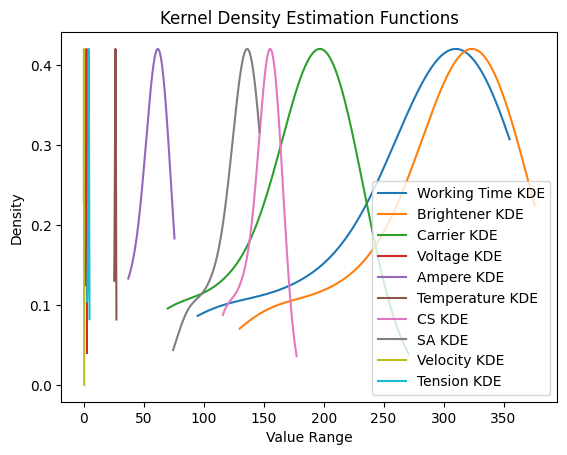

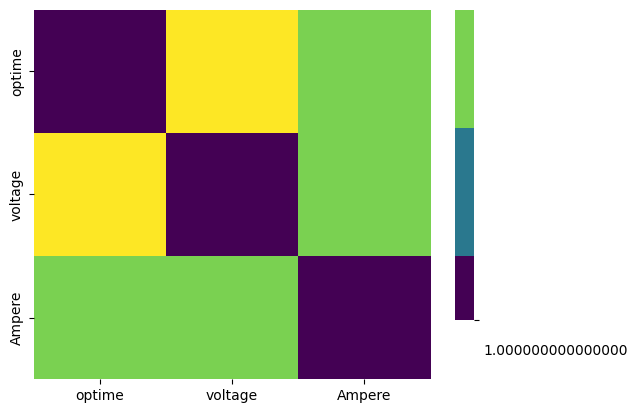

Epoch 1/20
140/140 [==============================] - 0s 941us/step - loss: 0.7327
Epoch 2/20
140/140 [==============================] - 0s 2ms/step - loss: 0.3856
Epoch 3/20
140/140 [==============================] - 0s 2ms/step - loss: 0.3129
Epoch 4/20
140/140 [==============================] - 0s 1ms/step - loss: 0.2601
Epoch 5/20
140/140 [==============================] - 0s 2ms/step - loss: 0.2163
Epoch 6/20
140/140 [==============================] - 0s 1ms/step - loss: 0.1801
Epoch 7/20
140/140 [==============================] - 0s 1ms/step - loss: 0.1500
Epoch 8/20
140/140 [==============================] - 0s 2ms/step - loss: 0.1250
Epoch 9/20
140/140 [==============================] - 0s 2ms/step - loss: 0.1043
Epoch 10/20
140/140 [==============================] - 0s 2ms/step - loss: 0.0871
Epoch 11/20
140/140 [==============================] - 0s 1ms/step - loss: 0.0728
Epoch 12/20
140/140 [==============================] - 0s 2ms/step - loss: 0.0610
Epoch 13/20
140/140 [==

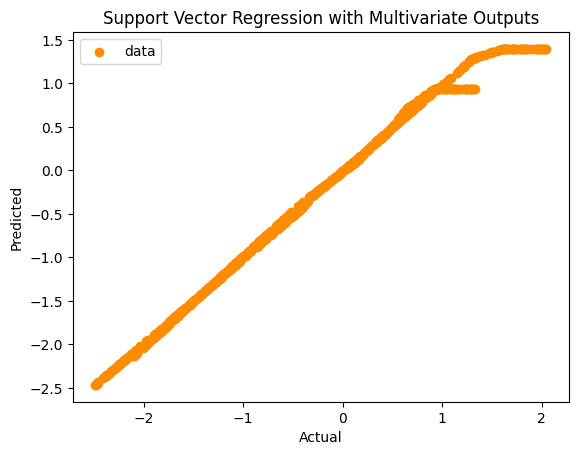

R-squared Result : 0.9885138595500619
     brightener   carrier
521   -0.498198  0.062054
737    0.328373  0.960304
740    0.339853  0.972780
660    0.033716  0.640094
411   -0.919137 -0.395389
..          ...       ...
468   -0.701014 -0.158350
935    1.086064  1.783700
428   -0.854083 -0.324693
7     -2.465132 -2.075450
155   -1.898778 -1.459982

[300 rows x 2 columns] [[-5.2000308e-01  3.9613962e-02]
 [ 3.1231427e-01  9.4622278e-01]
 [ 3.2449782e-01  9.5764065e-01]
 [ 2.7475059e-02  6.3344741e-01]
 [-9.3162704e-01 -3.6174619e-01]
 [ 9.2588484e-02  7.0760512e-01]
 [-9.5516920e-02  4.9337178e-01]
 [-5.4993927e-01  1.0424137e-02]
 [ 8.3546418e-01  1.3457428e+00]
 [-1.9632602e+00 -1.5513444e+00]
 [ 6.6876853e-01  1.2551384e+00]
 [-2.1883590e+00 -1.8119786e+00]
 [-5.9342980e-02  5.3457040e-01]
 [ 9.3956709e-01  1.3964460e+00]
 [ 9.3956709e-01  1.3964460e+00]
 [ 9.3956709e-01  1.3964460e+00]
 [-1.4230235e+00 -9.2582202e-01]
 [ 9.1130680e-01  1.3826818e+00]
 [ 4.0978324e-01  1.0375659e+00]

In [28]:
# kernel density estimation to resample more data
optime_kde = gaussian_kde(optime_mean_normalized)
brightener_kde = gaussian_kde(add_amount_brightener_normalized)
carrier_kde = gaussian_kde(add_amount_carrier_normalized)
voltage_kde = gaussian_kde(voltage_normalized)
ampere_kde = gaussian_kde(ampere_normalized)
temperature_kde = gaussian_kde(temperature_normalized)
cs_kde = gaussian_kde(cs_normalized)
sa_kde = gaussian_kde(sa_normalized)
velocity_kde = gaussian_kde(velocity_normalized)
tension_ked = gaussian_kde(tension_normalized)

# resample from kde
n_sample = 1000
# optime_resample = optime_kde.resample(size=n_sample)
# brightener_resample = brightener_kde.resample(size=n_sample)
# carrier_resample = carrier_kde.resample(size=n_sample)
# voltage_resample = voltage_kde.resample(size=n_sample)
# ampere_resample = ampere_kde.resample(size=n_sample)
# temperature_resample = temperature_kde.resample(size=n_sample)
# cs_resample = cs_kde.resample(size=n_sample)
# sa_resample = sa_kde.resample(size=n_sample)
# velocity_resample = velocity_kde.resample(size=n_sample)
# tension_resample = tension_ked.resample(size=n_sample)

x_optime = np.linspace(min(optime_mean_normalized), max(optime_mean_normalized), n_sample)
x_brightener = np.linspace(min(add_amount_brightener_normalized), max(add_amount_brightener_normalized), n_sample)
x_carrier = np.linspace(min(add_amount_carrier_normalized), max(add_amount_carrier_normalized), n_sample)
x_voltage = np.linspace(min(voltage_normalized), max(voltage_normalized), n_sample)
x_ampere = np.linspace(min(ampere_normalized), max(ampere_normalized), n_sample)
x_temperature = np.linspace(min(temperature_normalized), max(temperature_normalized), n_sample)
x_cs = np.linspace(min(cs_normalized), max(cs_normalized), n_sample)
x_sa = np.linspace(min(sa_normalized), max(sa_normalized), n_sample)
x_velocity = np.linspace(min(velocity_normalized), max(velocity_normalized), n_sample)
x_tension = np.linspace(min(tension_normalized), max(tension_normalized), n_sample)

optime_resample = optime_kde(x_optime)
brightener_resample = optime_kde(x_brightener)
carrier_resample = optime_kde(x_carrier)
voltage_resample = optime_kde(x_voltage)
ampere_resample = optime_kde(x_ampere)
temperature_resample = optime_kde(x_temperature)
cs_resample = optime_kde(x_cs)
sa_resample = optime_kde(x_sa)
velocity_resample = optime_kde(x_velocity)
tension_resample = optime_kde(x_tension)

rx_optime = optime_scaler.inverse_transform(x_optime.reshape(1, -1)).flatten()
rx_brightener = brightener_scaler.inverse_transform(x_brightener.reshape(1, -1)).flatten()
rx_carrier = carrier_scaler.inverse_transform(x_carrier.reshape(1, -1)).flatten()
rx_voltage = voltage_scaler.inverse_transform(x_voltage.reshape(1, -1)).flatten()
rx_ampere = ampere_scaler.inverse_transform(x_ampere.reshape(1, -1)).flatten()
rx_temperature = temperaature_scaler.inverse_transform(x_temperature.reshape(1, -1)).flatten()
rx_cs = cs_scaler.inverse_transform(x_cs.reshape(1, -1)).flatten()
rx_sa = sa_scaler.inverse_transform(x_sa.reshape(1, -1)).flatten()
rx_velocity = velocity_scaler.inverse_transform(x_velocity.reshape(1, -1)).flatten()
rx_tension = tension_scaler.inverse_transform(x_tension.reshape(1, -1)).flatten()


plt.plot(rx_optime, optime_resample, label='Working Time KDE')
plt.plot(rx_brightener, brightener_resample, label='Brightener KDE')
plt.plot(rx_carrier, carrier_resample, label='Carrier KDE')
plt.plot(rx_voltage, voltage_resample, label='Voltage KDE')
plt.plot(rx_ampere, ampere_resample, label='Ampere KDE')
plt.plot(rx_temperature, temperature_resample, label='Temperature KDE')
plt.plot(rx_cs, cs_resample, label='CS KDE')
plt.plot(rx_sa, sa_resample, label='SA KDE')
plt.plot(rx_velocity, velocity_resample, label='Velocity KDE')
plt.plot(rx_tension, tension_resample, label='Tension KDE')
plt.xlabel('Value Range')
plt.ylabel('Density')
plt.title('Kernel Density Estimation Functions')
plt.legend()
plt.show()


# correlation
X = pd.DataFrame([x_optime.T, x_voltage.T, x_ampere.T]).T
y = pd.DataFrame([x_brightener.T, x_carrier.T]).T
X.columns = ['optime', 'voltage', 'Ampere']
y.columns = ['brightener', 'carrier']
corr = X.corr()
sns.heatmap(corr, cmap='viridis')
plt.show()


# model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = Sequential([
    Dense(7, input_shape=(X.shape[1],), activation='relu'),
    #Dense(9, activation='relu'),
    Dense(3, activation='relu'),
    Dense(y.shape[1])
])

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=5)
y_pred = model.predict(X_test)

plt.scatter(y_test, y_pred, color='darkorange', label='data')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Support Vector Regression with Multivariate Outputs')
plt.legend()
plt.show()
    
r2 = r2_score(y_test, y_pred)
print(f"R-squared Result : {r2}")

print(y_test, y_pred)
